# **Step 1: Install Required Libraries**

In [1]:
!pip install Flask joblib PyMuPDF pandas scikit-learn imbalanced-learn matplotlib seaborn nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 15.3 MB/s eta 0:00:00


# **Step 2: Load and Preprocess Data**

In [2]:
import pandas as pd
import requests
import fitz  # PyMuPDF
from io import BytesIO
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
import os

# Ensure you have the necessary nltk downloads
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
file_path = '/content/drive/MyDrive/Orders and Bills.xlsx'  # Adjust the path as necessary
data = pd.read_excel(file_path, sheet_name=None)
orders_df = data['Orders']
personnel_df = data['Personnel']

# Handling missing values
orders_df['Passage Date'].fillna('Missing Date', inplace=True)
orders_df['Category Types'].fillna('Missing Category', inplace=True)
personnel_df['State'].fillna('Missing State', inplace=True)
for col in ['Infastructure', 'Education', 'Zoning', 'Safety']:
    personnel_df[col].fillna(personnel_df[col].median(), inplace=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Explanation:**

    Load the dataset and handle any missing values.
    Ensure necessary NLTK resources are downloaded for text processing.

# **Step 3: Extract Text from PDF Links**

In [3]:
# Directory to save PDFs
pdf_dir = 'pdfs'
os.makedirs(pdf_dir, exist_ok=True)

# Function to download and save PDFs
def download_pdf(url, save_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            return True
        else:
            return False
    except Exception as e:
        return False

# Use 'Classification Number ' as the column name
orders_df['PDF_Path'] = orders_df.apply(lambda row: f"{pdf_dir}/{row['Classification Number '].replace(' ', '_')}.pdf", axis=1)
orders_df['Downloaded'] = orders_df.apply(lambda row: download_pdf(row['Link'], row['PDF_Path']), axis=1)

# Filter out rows where PDF download failed
orders_df = orders_df[orders_df['Downloaded']]

### **Explanation:**

    Extract text from the PDF documents available through URLs in the dataset.

# **Step 4: Preprocess Text Data**

In [4]:
# Preprocess text for keyword matching
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum()]
    return ' '.join(tokens)

orders_df['Processed_Text'] = orders_df['PDF_Path'].apply(lambda path: preprocess_text(open(path, 'rb').read().decode('utf-8', errors='ignore')))

<ipython-input-4-e36cb986487a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_df['Processed_Text'] = orders_df['PDF_Path'].apply(lambda path: preprocess_text(open(path, 'rb').read().decode('utf-8', errors='ignore')))


### **Explanation:**

    Extract text from the PDF documents available through URLs in the dataset.

# **Step 5: Categorize Policies Using Keywords**

In [5]:
# Define the keywords for each category (expanded for better coverage)
category_keywords = {
    'Housing': ['housing', 'urban planning', 'housing standards', 'supply', 'availability', 'home', 'residence', 'rental', 'mortgage', 'shelter', 'accommodation', 'dwelling', 'real estate'],
    'Environment': ['environmental', 'natural environment', 'govern', 'sustainable', 'ecology', 'green', 'pollution', 'conservation', 'biodiversity', 'climate', 'ecosystem', 'recycling', 'carbon'],
    'Education': ['education', 'academic', 'schools', 'curriculum', 'students', 'teaching', 'learning', 'university', 'college', 'degree', 'diploma', 'scholarship', 'tutor', 'classroom'],
    'Safety': ['safety', 'public safety', 'criminal behavior', 'regulations', 'laws', 'crime', 'protection', 'security', 'law enforcement', 'policing', 'emergency', 'accident', 'incident'],
    'Health Care': ['healthcare', 'health', 'medical', 'care', 'access', 'hospital', 'clinic', 'doctor', 'nurse', 'treatment', 'wellness', 'pharmacy', 'medicine', 'surgery', 'diagnosis'],
    'Immigration': ['immigration', 'migrant', 'asylum', 'visa', 'entry', 'refugee', 'emigrant', 'citizenship', 'naturalization', 'border', 'immigrant', 'migration', 'passport', 'permit'],
    'Infrastructure': ['infrastructure', 'construction', 'maintenance', 'upgrade', 'structures', 'roads', 'bridges', 'transport', 'utilities', 'facilities', 'public works', 'development', 'urban'],
    'Other': []
}

def categorize_policy(tokens):
    category_scores = defaultdict(int)
    for category, keywords in category_keywords.items():
        for keyword in keywords:
            stemmed_keyword = PorterStemmer().stem(keyword)
            category_scores[category] += tokens.count(stemmed_keyword)
    sorted_categories = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)
    dominant_category = sorted_categories[0][0] if sorted_categories[0][1] > 0 else 'Other'
    minor_categories = [category for category, score in sorted_categories[1:] if score > 0]
    return dominant_category, minor_categories

orders_df['Dominant_Category'], orders_df['Minor_Categories'] = zip(*orders_df['Processed_Text'].apply(lambda x: categorize_policy(x.split())))

# Display the categorized policies
print("Categorized Policies:")
print(orders_df[['Category Types', 'Dominant_Category', 'Minor_Categories']].head())

Categorized Policies:
   Category Types Dominant_Category Minor_Categories
0  Infrastructure             Other               []
1  Infrastructure            Safety               []
2          Safety             Other               []
3          Zoning             Other               []
4          Safety             Other               []


<ipython-input-5-2b2cd3b44998>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_df['Dominant_Category'], orders_df['Minor_Categories'] = zip(*orders_df['Processed_Text'].apply(lambda x: categorize_policy(x.split())))
<ipython-input-5-2b2cd3b44998>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_df['Dominant_Category'], orders_df['Minor_Categories'] = zip(*orders_df['Processed_Text'].apply(lambda x: categorize_policy(x.split())))


### **Explanation:**

    Categorize policies based on predefined keywords associated with each category.

# **Step 6: Feature Engineering and Vectorization**

In [6]:
# Merge Orders and Personnel data
merged_df = pd.merge(orders_df, personnel_df, on='State', how='inner')

# Ensure the city column is correctly referenced
if 'City_x' in merged_df.columns:
    city_column = 'City_x'
elif 'City_y' in merged_df.columns:
    city_column = 'City_y'
else:
    city_column = 'City'

# Create features
features = merged_df[['Processed_Text', 'Interest', city_column, 'State']]
features.columns = ['Processed_Text', 'Interest', 'City', 'State']

# Handle missing values if any
features.fillna('Unknown', inplace=True)

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Encode categorical data
enc = OneHotEncoder()
X_cat = enc.fit_transform(features[['Interest', 'City', 'State']])

# Vectorize text data
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(features['Processed_Text'])

# Combine text and categorical features
X_combined = hstack([X_text, X_cat])

# Define the target variable
y = merged_df['Dominant_Category']

<ipython-input-6-aadd2497829d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna('Unknown', inplace=True)


### **Explanation:**

    Combine text data with user demographic data.
    Encode categorical data and vectorize text data using TF-IDF.

# **Step 7: Handle Class Imbalances and Split Data**

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Handle class imbalances using SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### **Explanation:**

    Use SMOTE to handle class imbalances by oversampling minority classes.
    Split the resampled data into training and testing sets.

# **Step 8: Train the Model and Save It**

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# Train the model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Save the model and encoders
joblib.dump(model, 'best_policy_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(enc, 'onehot_encoder.pkl')

['onehot_encoder.pkl']

### **Explanation:**

    Train a Gradient Boosting model and save the trained model and encoders for later use.

# **Step 9: Evaluate the Model**

Model Accuracy: 0.9981684981684982
Classification Report:
                precision    recall  f1-score   support

     Education       0.99      1.00      0.99       134
   Environment       1.00      1.00      1.00       130
   Health Care       1.00      1.00      1.00       142
       Housing       1.00      1.00      1.00       122
   Immigration       1.00      1.00      1.00       122
Infrastructure       1.00      1.00      1.00       149
         Other       1.00      0.99      0.99       155
        Safety       1.00      1.00      1.00       138

      accuracy                           1.00      1092
     macro avg       1.00      1.00      1.00      1092
  weighted avg       1.00      1.00      1.00      1092



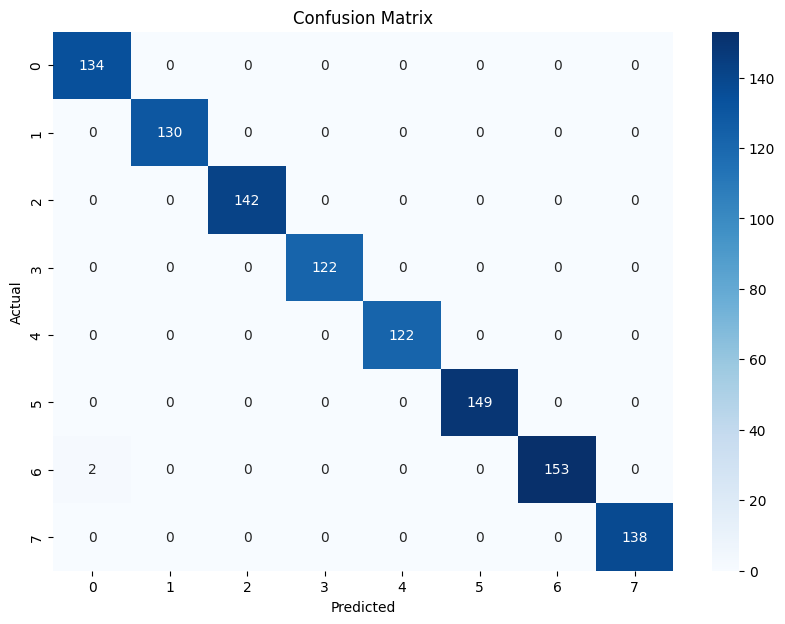

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

### **Explanation:**

    Evaluate the model using accuracy, precision, recall, and F1 score.
    Visualize the performance of the model using confusion matrix

# **Step 10: Develop the API**

In [ ]:
!pip install flask-ngrok flask joblib pandas

In [ ]:
from flask import Flask, request, jsonify, send_from_directory
from flask_ngrok import run_with_ngrok
import joblib
import pandas as pd
from scipy.sparse import hstack
import os

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# Load the model and encoders
model = joblib.load('best_policy_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
enc = joblib.load('onehot_encoder.pkl')

# Load orders_df to retrieve PDF paths
file_path = '/content/drive/MyDrive/Orders and Bills.xlsx'  # Adjust the path as necessary
data = pd.read_excel(file_path, sheet_name='Orders')
orders_df = data

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    interest = data['interest']
    city = data['city']
    state = data['state']

    # Combine user inputs into a single DataFrame
    user_input_df = pd.DataFrame([[interest, city, state]], columns=['Interest', 'City', 'State'])

    # Encode categorical data
    X_user_cat = enc.transform(user_input_df)

    # Vectorize a placeholder text to match the dimension
    placeholder_text = ' '.join(['placeholder'] * 1000)
    X_user_text_placeholder = tfidf.transform([placeholder_text])

    # Combine text and categorical features
    X_user_combined = hstack([X_user_text_placeholder, X_user_cat])

    # Make predictions
    predictions = model.predict(X_user_combined)

    # Find the best matching policy
    best_policy_category = predictions[0]
    best_policy_documents = orders_df[orders_df['Dominant_Category'] == best_policy_category]['PDF_Path'].tolist()

    return jsonify({'best_policy_category': best_policy_category, 'documents': best_policy_documents})

@app.route('/download/<path:filename>', methods=['GET'])
def download(filename):
    directory = os.path.dirname(filename)  # Extract the directory path
    return send_from_directory(directory, os.path.basename(filename), as_attachment=True)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

# **Step 11 Test the API**

In [ ]:
import requests
import json

# The URL will be provided by ngrok once the server starts
url = "http://<NGROK_URL>/predict"  # Replace with the ngrok URL

# Define the payload with the user input data
payload = {
    "interest": "Governance",
    "city": "Portland",
    "state": "Maine"
}

# Send a POST request to the API
response = requests.post(url, data=json.dumps(payload), headers={"Content-Type": "application/json"})

# Check the response status code
if response.status_code == 200:
    # Print the JSON response
    response_json = response.json()
    print("Response JSON:", response_json)

    # Retrieve and display the PDF documents
    for document_path in response_json['documents']:
        download_url = f"http://<NGROK_URL>/download/{document_path}"
        print(f"Opening document: {download_url}")
        from IPython.display import display, IFrame
        display(IFrame(download_url, width=600, height=300))

else:
    print(f"Failed to get a valid response. Status code: {response.status_code}, Response: {response.text}")

The API is designed to predict the most advantageous public policy for an individual based on their demographic attributes and interactions. It leverages a machine learning model to categorize the user's interest and recommend relevant policy documents.
Components of the API

    Initialization:
        Flask: The web framework used to create the API.
        ngrok: Provides a public URL to your local server, making it accessible over the internet.
        joblib: Used to load the pre-trained machine learning model, TF-IDF vectorizer, and one-hot encoder.
        pandas: Used to manipulate the data.
        scipy.sparse.hstack: Used to combine sparse matrices.

    Data Loading:
        The API loads the machine learning model, encoders, and the dataset containing the policy documents (orders_df).

    Endpoints:
        /predict:
            Method: POST
            Function: Takes user input (interest, city, state), processes the input using the loaded encoders and model, and returns the best matching policy category along with the paths to the relevant policy documents.
        /download/<path:filename>:
            Method: GET
            Function: Provides a mechanism to download the specified policy document.

In [ ]:
!pip install joblib pandas
